# Summary
__The Calibration Network / Inverse Mapping penalises now constraint violations!__


This code gives a short summary on the current progress (last update: 20.01.2020).
In the following a CNN aswell as a FFNN are trained to learn the mapping HNG-Parameters (w,a,b,g*,h0) to HNG-Volatility surface. A first approach on  training the inverse mapping with CNN is given. 
For the used dataset (50.000 szenarios), each szenario is generated as followed:
S&P500 returns are used to get optimal HNG parameters for each week in 2015 (10years rolling window). The initial variance is used as variable aswell.
Afterwards for each week in 2015 Call Prices are used to get optimal HNG parameters. The initial variance is set to the corrensponding value from MLE optimization.
Those 52 optimal parameters combinations are then used as bounds. 
To generate a szenario a random value between the bounds is uniformly choosen (initial variance included)
and a grid of implied variance is calculated for Maturities [30, 60, 90, 120, 150, 180, 210] days and Moneyness     [0.9, 0.925, 0.95, 0.975, 1.0, 1.025, 1.05, 1.075, 1.1].


# 1. Preambel and Data Import

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3944662854027404228
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1447932723
locality {
  bus_id: 1
  links {
  }
}
incarnation: 938266650479864677
physical_device_desc: "device: 0, name: GeForce GTX 750 Ti, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [1]:
# Preambel
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import InputLayer,Dense,Flatten, Conv2D, Dropout, Input,ZeroPadding2D,MaxPooling2D
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
#import py_vollib.black_scholes.implied_volatility as vol
#import time
import scipy
import scipy.io
import tensorflow as tf

# scaler
def ytransform(y_train,y_val,y_test):
    #return [scale.transform(y_train),scale.transform(y_val), 
    #        scale.transform(y_test)]
    return [y_train,y_val,y_test]

def yinversetransform(y):
    return y
    #return scale.inverse_transform(y)
    
def myscale(x):
    res=np.zeros(Nparameters)
    for i in range(Nparameters):
        res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i])
    return res

def myinverse(x):
    res=np.zeros(Nparameters)
    for i in range(Nparameters):
        res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
    return res

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))   
def root_relative_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square((y_pred - y_true)/y_true)))   

def rmse_constraint(param):
    def rel_mse_constraint(y_true, y_pred):
            traf_a = 0.5*(y_pred[:,0]*diff[0]+bound_sum[0])
            traf_g = 0.5*(y_pred[:,2]*diff[2]+bound_sum[2])
            traf_b = 0.5*(y_pred[:,1]*diff[1]+bound_sum[1])
            constraint = traf_a*K.square(traf_g)+traf_b
            #constraint = K.variable(value=constraint, dtype='float64')
            return K.sqrt(K.mean(K.square((y_pred - y_true)/y_true)))  +param*K.mean(K.greater(constraint,1))
    return rel_mse_constraint
def mse_constraint(param):
    def rel_mse_constraint(y_true, y_pred):
            traf_a = 0.5*(y_pred[:,0]*diff[0]+bound_sum[0])
            traf_g = 0.5*(y_pred[:,2]*diff[2]+bound_sum[2])
            traf_b = 0.5*(y_pred[:,1]*diff[1]+bound_sum[1])
            constraint = traf_a*K.square(traf_g)+traf_b
            #constraint = K.variable(value=constraint, dtype='float64')
            return K.mean(K.square(y_pred - y_true)) +param*K.mean(K.greater(constraint,1))
    return rel_mse_constraint
    
# Data Import
mat         = scipy.io.loadmat('data_vola_maxbounds_50000_0005_09_11_30_210.mat')
data        = mat['data_vola']
Nparameters = 5
maturities  = np.array([30, 60, 90, 120, 150, 180, 210])
strikes     = np.array([0.9, 0.925, 0.95, 0.975, 1.0, 1.025, 1.05, 1.075, 1.1])
Nstrikes    = len(strikes)   
Nmaturities = len(maturities)   
xx          = data[:,:Nparameters]
yy          = data[:,Nparameters+2:]

ub=np.amax(xx, axis=0)
lb=np.amin(xx, axis=0)
diff = ub-lb
bound_sum =ub+lb

# split into train and test sample
X_train, X_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15)#, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
   X_train, y_train, test_size=0.15)#, random_state=42)

Ntest= X_test.shape[0]
Ntrain= X_train.shape[0]
Nval= X_val.shape[0]
tf.keras.backend.set_floatx('float64')  

# 2. CNN as Encoder / Pricing Kernel

In [2]:
# reshaping train/test sets for structure purposes
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.compat.v1.Session(config=config)
set_session(sess)

[y_train_trafo, y_val_trafo, y_test_trafo]=ytransform(y_train, y_val, y_test)
y_train_trafo = np.asarray([y_train[i,:].reshape((1,Nmaturities,Nstrikes)) for i in range(Ntrain)])
y_val_trafo =  np.asarray([y_val[i,:].reshape((1,Nmaturities,Nstrikes)) for i in range(Nval)])
y_test_trafo =  np.asarray([y_test[i,:].reshape((1,Nmaturities,Nstrikes)) for i in range(Ntest)])

X_train_trafo = np.array([myscale(x) for x in X_train])
X_val_trafo   = np.array([myscale(x) for x in X_val])
X_test_trafo  = np.array([myscale(x) for x in X_test])
X_train_trafo = np.array([myscale(x) for x in X_train])
X_val_trafo   = np.array([myscale(x) for x in X_val])
X_test_trafo  = X_test_trafo.reshape((Ntest,5,1,1))
X_train_trafo = X_train_trafo.reshape((Ntrain,5,1,1))
X_val_trafo   = X_val_trafo.reshape((Nval,5,1,1))


In [3]:
NN1 = Sequential() 
NN1.add(InputLayer(input_shape=(Nparameters,1,1,)))
NN1.add(ZeroPadding2D(padding=(2, 2)))
NN1.add(Conv2D(32, (3, 1), padding='valid',use_bias =True,strides =(1,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(1,1),activation ='elu'))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (3,3),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
#NN1.add(MaxPooling2D(pool_size=(2, 1)))
#NN1.add(Dropout(0.25))
#NN1.add(ZeroPadding2D(padding=(0,1)))
NN1.add(Conv2D(Nstrikes, (2, 1),padding='valid',use_bias =True,strides =(2,1),activation ='linear', kernel_constraint = tf.keras.constraints.NonNeg()))
#NN1.add(MaxPooling2D(pool_size=(4, 1)))
NN1.summary()
#NN1.compile(loss = "MSE", optimizer = "adam",metrics=["MAPE","MSE"])
NN1.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])
NN1.fit(X_train_trafo, y_train_trafo, batch_size=64, validation_data = (X_val_trafo, y_val_trafo),
        epochs = 30, verbose = True, shuffle=1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 9, 5, 1)           0         
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 5, 32)          128       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 9, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 6, 32)          4128      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 5, 32)          4128      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 6, 7, 32)          0         
____

36085/36085 [==============================] - 8s 215us/sample - loss: 0.0492 - mean_absolute_percentage_error: 3.2090 - mean_squared_error: 3.4258e-04 - val_loss: 0.0502 - val_mean_absolute_percentage_error: 3.5890 - val_mean_squared_error: 3.4290e-04
Epoch 23/30
36085/36085 [==============================] - 8s 217us/sample - loss: 0.0537 - mean_absolute_percentage_error: 3.6411 - mean_squared_error: 3.5267e-04 - val_loss: 0.0632 - val_mean_absolute_percentage_error: 5.2635 - val_mean_squared_error: 3.0108e-04
Epoch 24/30
36085/36085 [==============================] - 8s 217us/sample - loss: 0.0508 - mean_absolute_percentage_error: 3.4341 - mean_squared_error: 3.1547e-04 - val_loss: 0.0488 - val_mean_absolute_percentage_error: 3.4156 - val_mean_squared_error: 3.5239e-04
Epoch 25/30
36085/36085 [==============================] - 8s 214us/sample - loss: 0.0481 - mean_absolute_percentage_error: 3.1788 - mean_squared_error: 3.2002e-04 - val_loss: 0.0371 - val_mean_absolute_percentage_err

### 2.1 Results 
The following plots show the performance on the testing set

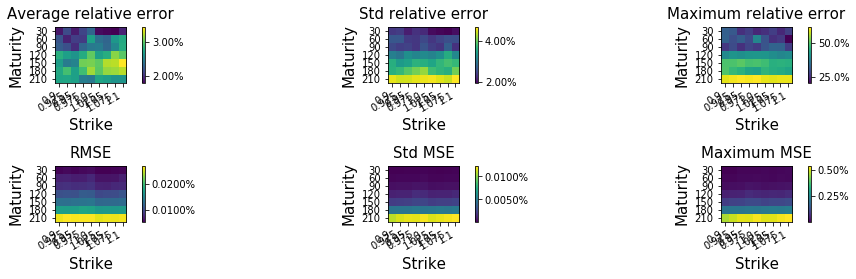

In [5]:
#error plots
S0=1.
y_test_re    = yinversetransform(y_test_trafo).reshape((Ntest,Nmaturities,Nstrikes))
prediction   = NN1.predict(X_test_trafo).reshape((Ntest,Nmaturities,Nstrikes))
err_rel_mat  = np.zeros(prediction.shape)
err_mat      = np.zeros(prediction.shape)
for i in range(Ntest):
    err_rel_mat[i,:,:] =  np.abs((y_test_re[i,:,:]-prediction[i,:,:])/y_test_re[i,:,:])
    err_mat[i,:,:] =  np.square((y_test_re[i,:,:]-prediction[i,:,:]))
idx = np.argsort(np.max(err_rel_mat,axis=tuple([1,2])), axis=None)

#bad_idx = idx[:-200]
bad_idx = idx
#from matplotlib.colors import LogNorm
plt.figure(figsize=(14,4))
ax=plt.subplot(2,3,1)
err1 = 100*np.mean(err_rel_mat[bad_idx,:,:],axis=0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,2)
err2 = 100*np.std(err_rel_mat[bad_idx,:,:],axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,3)
err3 = 100*np.max(err_rel_mat[bad_idx,:,:],axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,4)
err1 = np.sqrt(np.mean(err_mat[bad_idx,:,:],axis=0))
plt.title("RMSE",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,5)
err2 = np.std(err_mat[bad_idx,:,:],axis = 0)
plt.title("Std MSE",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,6)
err3 = np.max(err_mat[bad_idx,:,:],axis = 0)
plt.title("Maximum MSE",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.show()

# 3. CNN as  Decoder/Inverse Mapping / Calibration

In [6]:
# reshaping for cnn purposes
y_train_trafo2 = y_train_trafo.reshape((Ntrain,Nmaturities,Nstrikes,1))
y_test_trafo2 = y_test_trafo.reshape((Ntest,Nmaturities,Nstrikes,1))
y_val_trafo2 = y_val_trafo.reshape((Nval,Nmaturities,Nstrikes,1))
X_val_trafo2 = X_val_trafo.reshape((Nval,Nparameters))
X_train_trafo2 = X_train_trafo.reshape((Ntrain,Nparameters))
X_test_trafo2 = X_test_trafo.reshape((Ntest,Nparameters))
""" old structure with multi-purpose network 
input1 = Input(shape = (7,9,1))
x1 = Conv2D(64, kernel_size=3, activation='relu')(input1)
x2 = Conv2D(64, kernel_size=3, activation='relu')(x1)
x3 = Flatten()(x2)
x4 = Dense(50, activation = 'elu')(x3)
seq1 = Dense(1, activation = 'linear',use_bias=True)(x4)
seq2 = Dense(1, activation = 'linear',use_bias=True)(x4)
seq3 = Dense(1, activation = 'linear',use_bias=True)(x4)
seq4 = Dense(1, activation = 'linear',use_bias=True)(x4)
seq5 = Dense(1, activation = 'linear',use_bias=True)(x4)
out1 = keras.layers.merge.concatenate([seq1, seq2, seq3,seq4,seq5], axis=-1)
NN2 = Model(inputs=input1, outputs=out1)
"""

" old structure with multi-purpose network \ninput1 = Input(shape = (7,9,1))\nx1 = Conv2D(64, kernel_size=3, activation='relu')(input1)\nx2 = Conv2D(64, kernel_size=3, activation='relu')(x1)\nx3 = Flatten()(x2)\nx4 = Dense(50, activation = 'elu')(x3)\nseq1 = Dense(1, activation = 'linear',use_bias=True)(x4)\nseq2 = Dense(1, activation = 'linear',use_bias=True)(x4)\nseq3 = Dense(1, activation = 'linear',use_bias=True)(x4)\nseq4 = Dense(1, activation = 'linear',use_bias=True)(x4)\nseq5 = Dense(1, activation = 'linear',use_bias=True)(x4)\nout1 = keras.layers.merge.concatenate([seq1, seq2, seq3,seq4,seq5], axis=-1)\nNN2 = Model(inputs=input1, outputs=out1)\n"

In [7]:
NN2 = Sequential() 
NN2.add(InputLayer(input_shape=(Nmaturities,Nstrikes,1)))
NN2.add(Conv2D(64,(3, 3),use_bias= True, padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(MaxPooling2D(pool_size=(2, 2)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Flatten())
NN2.add(Dense(5,activation = 'linear',use_bias=True))
NN2.summary()


#NN2.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])
NN2.compile(loss =mse_constraint(0.25), optimizer = "adam",metrics=["MAPE", "MSE"])
history = NN2.fit(y_train_trafo2,X_train_trafo2, batch_size=50, validation_data = (y_val_trafo2,X_val_trafo2),
    epochs=30, verbose = True, shuffle=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 5, 7, 64)          640       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 6, 64)          16448     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 3, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 2, 64)          16448     
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 3, 4, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 2, 3, 64)          16448     
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 4, 5, 64)         

36085/36085 [==============================] - 18s 492us/sample - loss: 0.0830 - mean_absolute_percentage_error: 160.5271 - mean_squared_error: 0.0773 - val_loss: 0.0843 - val_mean_absolute_percentage_error: 75.4501 - val_mean_squared_error: 0.0761
Epoch 24/30
36085/36085 [==============================] - 18s 492us/sample - loss: 0.0816 - mean_absolute_percentage_error: 158.0965 - mean_squared_error: 0.0766 - val_loss: 0.0799 - val_mean_absolute_percentage_error: 77.6417 - val_mean_squared_error: 0.0769
Epoch 25/30
36085/36085 [==============================] - 18s 488us/sample - loss: 0.0814 - mean_absolute_percentage_error: 122.1658 - mean_squared_error: 0.0760 - val_loss: 0.0836 - val_mean_absolute_percentage_error: 68.6322 - val_mean_squared_error: 0.0775
Epoch 26/30
36085/36085 [==============================] - 18s 499us/sample - loss: 0.0813 - mean_absolute_percentage_error: 138.6121 - mean_squared_error: 0.0759 - val_loss: 0.0861 - val_mean_absolute_percentage_error: 73.4709 -

### 3.1 Results
Take care these results are on scaled parameter values and not rescaled yet!

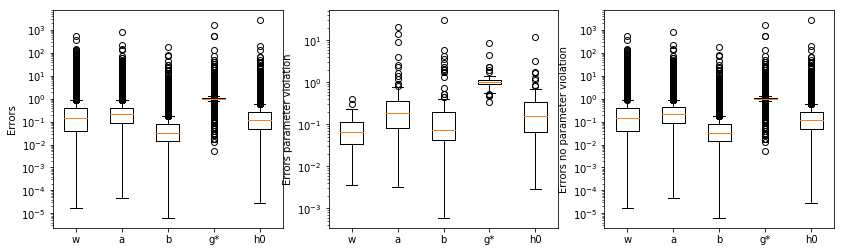

violation error mean in %: [  8.4187434   77.00989126  67.1484046  113.29217179  39.90189646]
no violation error mean in %: [ 75.53677453  77.46361518  18.55120871 149.27870888  80.63372721]
violation error median in %: [  6.46505376  18.39210372   7.27434901 100.82125763  15.53262709]
no violation error median in %: [ 14.9841949   20.87411482   3.16670624 100.14219594  11.3083083 ]
error mean in %: [ 74.63207399  77.45749932  19.20626233 148.79363744  80.08469279]
error median in %: [ 14.50378283  20.82349843   3.20592256 100.14313156  11.33967485]


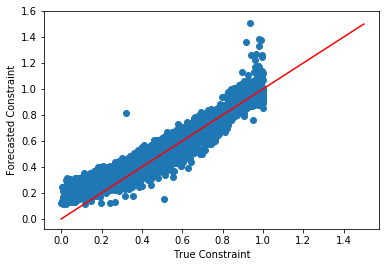

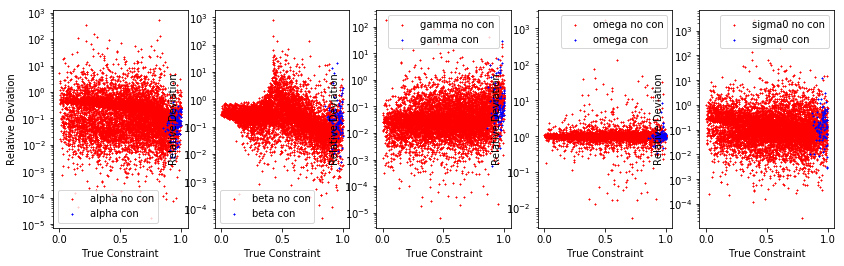

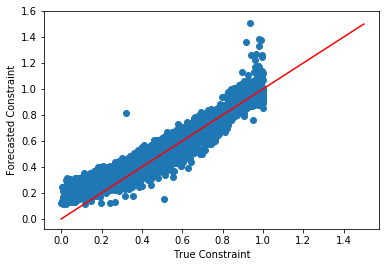

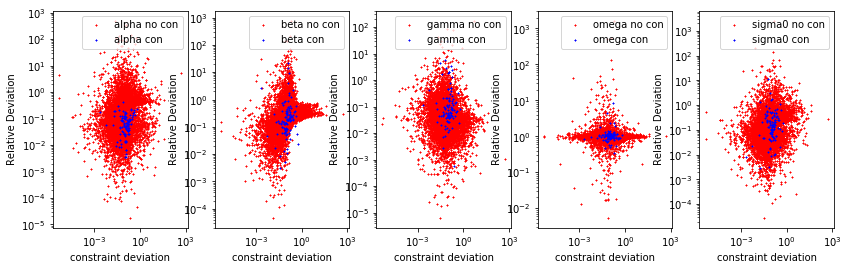

In [26]:
def constraint_violation(x):
    return np.sum(x[:,0]*x[:,2]**2+x[:,1]>=1)/x.shape[0],x[:,0]*x[:,2]**2+x[:,1]>=1,x[:,0]*x[:,2]**2+x[:,1]
prediction = NN2.predict(y_test_trafo2)

prediction_invtrafo= np.array([myinverse(x) for x in prediction])

prediction = NN2.predict(y_test_trafo2)
prediction_std = np.std(prediction,axis=0)
error = np.zeros((Ntest,Nparameters))
for i in range(Ntest):
    error[i,:] =  np.abs((X_test_trafo2[i,:]-prediction[i,:])/X_test_trafo2[i,:])
err1 = np.mean(error,axis = 0)
err2 = np.median(error,axis = 0)
err_std = np.std(error,axis = 0)
idx = np.argsort(error[:,0], axis=None)
good_idx = idx[:-100]


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
_,_,c =constraint_violation(prediction_invtrafo)
_,_,c2 =constraint_violation(X_test)


testing_violation = c>=1
testing_violation2 = (c<1)
vio_error = error[testing_violation,:]
vio_error2 = error[testing_violation2,:]


plt.figure(figsize=(14,4))
ax=plt.subplot(1,3,1)
plt.boxplot(error)
plt.yscale("log")
plt.xticks([1, 2, 3,4,5], ['w','a','b','g*','h0'])
plt.ylabel("Errors")
ax=plt.subplot(1,3,2)
plt.boxplot(vio_error)
plt.yscale("log")
plt.xticks([1, 2, 3,4,5], ['w','a','b','g*','h0'])
plt.ylabel("Errors parameter violation")
ax=plt.subplot(1,3,3)
plt.boxplot(vio_error2)
plt.yscale("log")
plt.xticks([1, 2, 3,4,5], ['w','a','b','g*','h0'])
plt.ylabel("Errors no parameter violation")
plt.show()

print("violation error mean in %:",100*np.mean(vio_error,axis=0))
print("no violation error mean in %:",100*np.mean(vio_error2,axis=0))
print("violation error median in %:",100*np.median(vio_error,axis=0))
print("no violation error median in %:",100*np.median(vio_error2,axis=0))
print("error mean in %:",100*err1)
print("error median in %:",100*err2)

fig = plt.figure()
plt.scatter(c2,c)
plt.plot(np.arange(0, np.max(c),0.5),np.arange(0, np.max(c),0.5),'-r')
plt.xlabel("True Constraint")
plt.ylabel("Forecasted Constraint")


plt.figure(figsize=(14,4))
ax=plt.subplot(1,5,1)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,0],c="r",s=1,marker="x",label="alpha no con")
plt.scatter(c2[testing_violation],vio_error[:,0],c="b",s=1,marker="x",label="alpha con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,2)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,1],c="r",s=1,marker="x",label="beta no con")
plt.scatter(c2[testing_violation],vio_error[:,1],c="b",s=1,marker="x",label="beta con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,3)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,2],c="r",s=1,marker="x",label="gamma no con")
plt.scatter(c2[testing_violation],vio_error[:,2],c="b",s=1,marker="x",label="gamma con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,4)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,3],c="r",s=1,marker="x",label="omega no con")
plt.scatter(c2[testing_violation],vio_error[:,3],c="b",s=1,marker="x",label="omega con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,5)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,4],c="r",s=1,marker="x",label="sigma0 no con")
plt.scatter(c2[testing_violation],vio_error[:,4],c="b",s=1,marker="x",label="sigma0 con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
fig = plt.figure()
plt.scatter(c2,c)
plt.plot(np.arange(0, np.max(c),0.5),np.arange(0, np.max(c),0.5),'-r')
plt.xlabel("True Constraint")
plt.ylabel("Forecasted Constraint")

plt.figure(figsize=(14,4))
ax=plt.subplot(1,5,1)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,0],c="r",s=1,marker="x",label="alpha no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,0],c="b",s=1,marker="x",label="alpha con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,2)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,1],c="r",s=1,marker="x",label="beta no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,1],c="b",s=1,marker="x",label="beta con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,3)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,2],c="r",s=1,marker="x",label="gamma no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,2],c="b",s=1,marker="x",label="gamma con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,4)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,3],c="r",s=1,marker="x",label="omega no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,3],c="b",s=1,marker="x",label="omega con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,5)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,4],c="r",s=1,marker="x",label="sigma0 no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,4],c="b",s=1,marker="x",label="sigma0 con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()



# 3.2 Testing the performace of the AutoEncoder/Decoder Combination
We test how the two previously trained NN work together. First, HNG-Vola surfaces are used to predict the underlying parameters with NN2. Those predictions are fed into NN1 to get Vola-Surface again. The results are shown below.

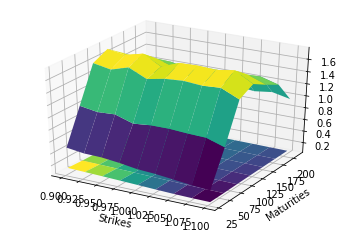

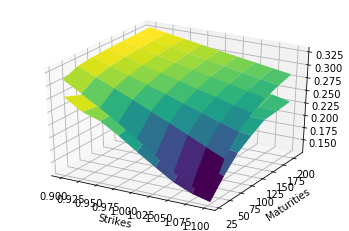

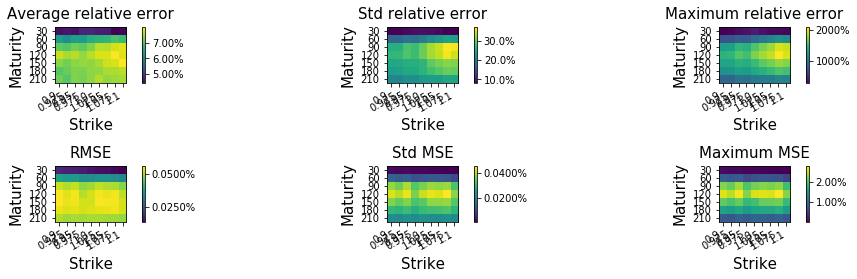

In [27]:
prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
forecast = NN1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
y_true_test = y_test_trafo2.reshape(Ntest,Nmaturities,Nstrikes)
# Example Plots
X = strikes
Y = maturities
X, Y = np.meshgrid(X, Y)
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
import random
sample_idx = random.randint(0,len(y_test))

#error plots
mape = np.zeros(forecast.shape)
mse  = np.zeros(forecast.shape)
err_rel_mat  = np.zeros(prediction.shape)
err_mat      = np.zeros(prediction.shape)
for i in range(Ntest):
    mape[i,:,:] =  np.abs((y_true_test[i,:,:]-forecast[i,:,:])/y_true_test[i,:,:])
    mse[i,:,:]  =  np.square((y_true_test[i,:,:]-forecast[i,:,:]))
idx = np.argsort(np.max(mape,axis=tuple([1,2])), axis=None)

#bad_idx = idx[:-200]
bad_idx = idx

fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, y_true_test[idx[-1],:,:], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.plot_surface(X, Y, forecast[idx[-1],:,:] , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
plt.show()
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, y_true_test[sample_idx,:,:], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.plot_surface(X, Y, forecast[sample_idx,:,:] , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
plt.show()
#from matplotlib.colors import LogNorm
plt.figure(figsize=(14,4))
ax=plt.subplot(2,3,1)
err1 = 100*np.mean(mape[bad_idx,:,:],axis=0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,2)
err2 = 100*np.std(mape[bad_idx,:,:],axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,3)
err3 = 100*np.max(mape[bad_idx,:,:],axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,4)
err1 = np.sqrt(np.mean(mse[bad_idx,:,:],axis=0))
plt.title("RMSE",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,5)
err2 = np.std(mse[bad_idx,:,:],axis = 0)
plt.title("Std MSE",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,6)
err3 = np.max(mse[bad_idx,:,:],axis = 0)
plt.title("Maximum MSE",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.show()

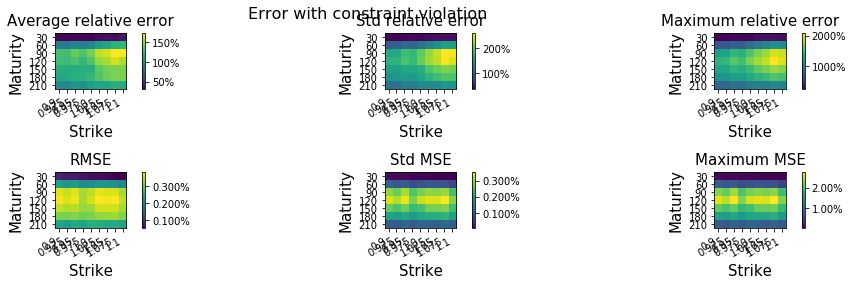

In [28]:
#from matplotlib.colors import LogNorm
plt.figure(figsize=(14,4))
plt.suptitle('Error with constraint violation', fontsize=16)
ax=plt.subplot(2,3,1)
bad_idx = testing_violation
err1 = 100*np.mean(mape[bad_idx,:,:],axis=0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,2)
err2 = 100*np.std(mape[bad_idx,:,:],axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,3)
err3 = 100*np.max(mape[bad_idx,:,:],axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,4)
err1 = np.sqrt(np.mean(mse[bad_idx,:,:],axis=0))
plt.title("RMSE",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,5)
err2 = np.std(mse[bad_idx,:,:],axis = 0)
plt.title("Std MSE",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,6)
err3 = np.max(mse[bad_idx,:,:],axis = 0)
plt.title("Maximum MSE",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.show()

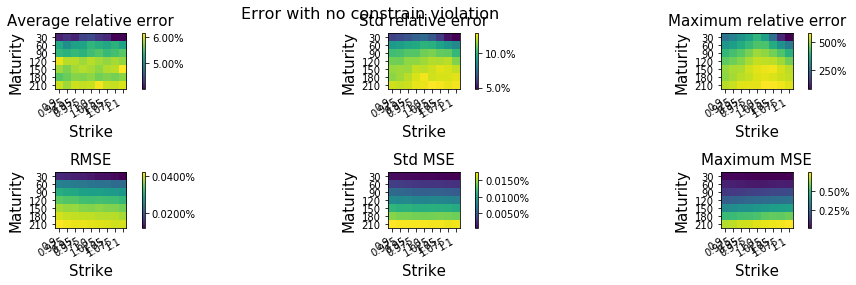

In [30]:
#from matplotlib.colors import LogNorm
plt.figure(figsize=(14,4))
plt.suptitle('Error with no constrain violation', fontsize=16)
ax=plt.subplot(2,3,1)
bad_idx = testing_violation2
err1 = 100*np.mean(mape[bad_idx,:,:],axis=0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,2)
err2 = 100*np.std(mape[bad_idx,:,:],axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,3)
err3 = 100*np.max(mape[bad_idx,:,:],axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,4)
err1 = np.sqrt(np.mean(mse[bad_idx,:,:],axis=0))
plt.title("RMSE",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,5)
err2 = np.std(mse[bad_idx,:,:],axis = 0)
plt.title("Std MSE",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,6)
err3 = np.max(mse[bad_idx,:,:],axis = 0)
plt.title("Maximum MSE",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.show()

# 3.1 No parameter constraint

In [10]:
NN2a = Sequential() 
NN2a.add(InputLayer(input_shape=(Nmaturities,Nstrikes,1)))
NN2a.add(Conv2D(64,(3, 3),use_bias= True, padding='valid',strides =(1,1),activation ='tanh'))
NN2a.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2a.add(MaxPooling2D(pool_size=(2, 2)))
NN2a.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2a.add(ZeroPadding2D(padding=(1,1)))
NN2a.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2a.add(ZeroPadding2D(padding=(1,1)))
NN2a.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2a.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2a.add(ZeroPadding2D(padding=(1,1)))
NN2a.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2a.add(ZeroPadding2D(padding=(1,1)))
NN2a.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2a.add(Flatten())
NN2a.add(Dense(5,activation = 'linear',use_bias=True))
NN2a.summary()


NN2a.compile(loss = "MSE", optimizer = "adam",metrics=["MAPE","MSE"])
#NN2.compile(loss =mse_constraint(0.25), optimizer = "adam",metrics=["MAPE", "MSE"])
#NN2.fit(y_train_trafo2,X_train_trafo2, batch_size=50, validation_data = (y_val_trafo2,X_val_trafo2),
#        epochs = 50, verbose = True, shuffle=1)
history = NN2a.fit(y_train_trafo2,X_train_trafo2, batch_size=50, validation_data = (y_val_trafo2,X_val_trafo2),
    epochs=30, verbose = True, shuffle=1)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 5, 7, 64)          640       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4, 6, 64)          16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 3, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 1, 2, 64)          16448     
_________________________________________________________________
zero_padding2d_9 (ZeroPaddin (None, 3, 4, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 2, 3, 64)          16448     
_________________________________________________________________
zero_padding2d_10 (ZeroPaddi (None, 4, 5, 64)         

36085/36085 [==============================] - 18s 498us/sample - loss: 0.0764 - mean_absolute_percentage_error: 155.2137 - mean_squared_error: 0.0764 - val_loss: 0.0790 - val_mean_absolute_percentage_error: 96.9619 - val_mean_squared_error: 0.0790
Epoch 24/30
36085/36085 [==============================] - 18s 508us/sample - loss: 0.0767 - mean_absolute_percentage_error: 157.3371 - mean_squared_error: 0.0767 - val_loss: 0.0780 - val_mean_absolute_percentage_error: 75.4210 - val_mean_squared_error: 0.0780
Epoch 25/30
36085/36085 [==============================] - 18s 492us/sample - loss: 0.0772 - mean_absolute_percentage_error: 166.4478 - mean_squared_error: 0.0772 - val_loss: 0.0769 - val_mean_absolute_percentage_error: 69.3543 - val_mean_squared_error: 0.0769
Epoch 26/30
36085/36085 [==============================] - 18s 502us/sample - loss: 0.0758 - mean_absolute_percentage_error: 144.7372 - mean_squared_error: 0.0758 - val_loss: 0.0742 - val_mean_absolute_percentage_error: 77.4066 -

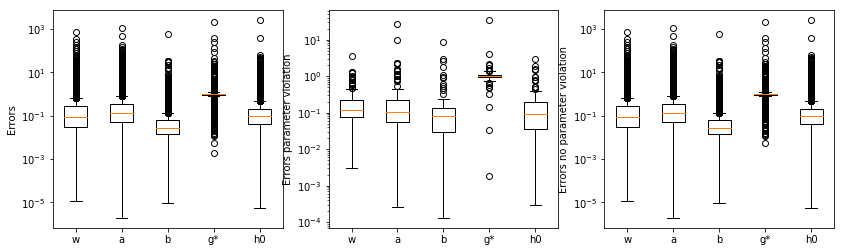

error mean in %: [ 73.27248729  97.89983916  22.37679329 148.6105341   75.88702038]
error median in %: [ 8.51722507 12.83528547  2.83550826 99.97499911  9.61879282]
violation error mean in %: [ 23.90636349  54.13795777  24.50521933 130.4815164   20.38453235]
no violation error mean in %: [ 74.0963724   98.63019349  22.34127139 148.91309437  76.81331699]
violation error median in %: [ 11.80593568  10.24889539   8.26723168 100.00641539   9.271733  ]
no violation error median in %: [ 8.36459619 12.9063618   2.80027134 99.97198806  9.66275523]


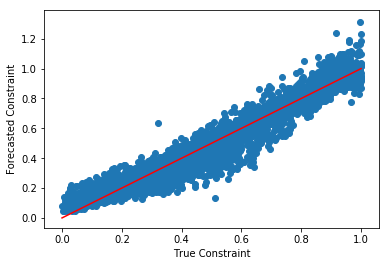

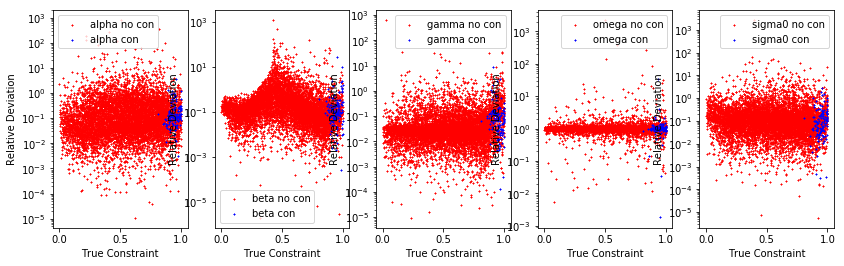

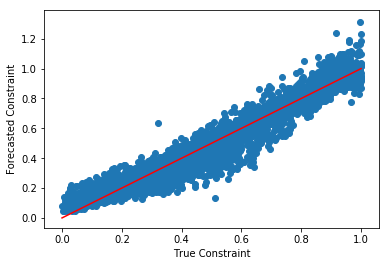

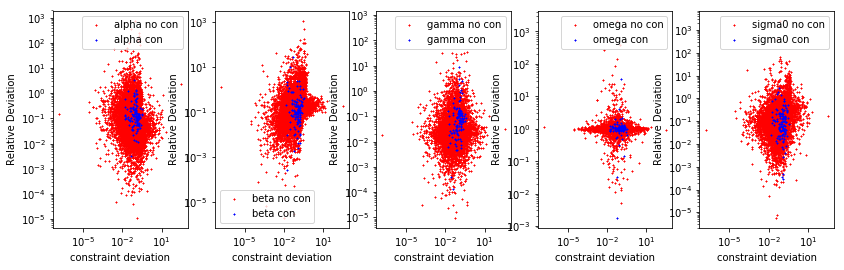

In [20]:
prediction = NN2a.predict(y_test_trafo2)

prediction_invtrafo= np.array([myinverse(x) for x in prediction])

prediction = NN2a.predict(y_test_trafo2)
prediction_std = np.std(prediction,axis=0)
error = np.zeros((Ntest,Nparameters))
for i in range(Ntest):
    error[i,:] =  np.abs((X_test_trafo2[i,:]-prediction[i,:])/X_test_trafo2[i,:])
err1 = np.mean(error,axis = 0)
err2 = np.median(error,axis = 0)
err_std = np.std(error,axis = 0)
idx = np.argsort(error[:,0], axis=None)
good_idx = idx[:-100]
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
_,_,c =constraint_violation(prediction_invtrafo)
_,_,c2 =constraint_violation(X_test)


testing_violation = c>=1
testing_violation2 = (c<1)
plt.figure(figsize=(14,4))
ax=plt.subplot(1,3,1)
plt.boxplot(error)
plt.yscale("log")
plt.xticks([1, 2, 3,4,5], ['w','a','b','g*','h0'])
plt.ylabel("Errors")

vio_error = error[testing_violation,:]
vio_error2 = error[testing_violation2,:]
ax=plt.subplot(1,3,2)

plt.boxplot(vio_error)
plt.yscale("log")
plt.xticks([1, 2, 3,4,5], ['w','a','b','g*','h0'])
plt.ylabel("Errors parameter violation")
ax=plt.subplot(1,3,3)

plt.boxplot(vio_error2)
plt.yscale("log")
plt.xticks([1, 2, 3,4,5], ['w','a','b','g*','h0'])
plt.ylabel("Errors no parameter violation")
plt.show()
print("error mean in %:",100*err1)
print("error median in %:",100*err2)
print("violation error mean in %:",100*np.mean(vio_error,axis=0))
print("no violation error mean in %:",100*np.mean(vio_error2,axis=0))
print("violation error median in %:",100*np.median(vio_error,axis=0))
print("no violation error median in %:",100*np.median(vio_error2,axis=0))


fig = plt.figure()
plt.scatter(c2,c)
plt.plot(np.arange(0, np.max(c),0.5),np.arange(0, np.max(c),0.5),'-r')
plt.xlabel("True Constraint")
plt.ylabel("Forecasted Constraint")


plt.figure(figsize=(14,4))
ax=plt.subplot(1,5,1)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,0],c="r",s=1,marker="x",label="alpha no con")
plt.scatter(c2[testing_violation],vio_error[:,0],c="b",s=1,marker="x",label="alpha con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,2)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,1],c="r",s=1,marker="x",label="beta no con")
plt.scatter(c2[testing_violation],vio_error[:,1],c="b",s=1,marker="x",label="beta con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,3)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,2],c="r",s=1,marker="x",label="gamma no con")
plt.scatter(c2[testing_violation],vio_error[:,2],c="b",s=1,marker="x",label="gamma con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,4)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,3],c="r",s=1,marker="x",label="omega no con")
plt.scatter(c2[testing_violation],vio_error[:,3],c="b",s=1,marker="x",label="omega con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,5)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,4],c="r",s=1,marker="x",label="sigma0 no con")
plt.scatter(c2[testing_violation],vio_error[:,4],c="b",s=1,marker="x",label="sigma0 con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
fig = plt.figure()
plt.scatter(c2,c)
plt.plot(np.arange(0, np.max(c),0.5),np.arange(0, np.max(c),0.5),'-r')
plt.xlabel("True Constraint")
plt.ylabel("Forecasted Constraint")

plt.figure(figsize=(14,4))
ax=plt.subplot(1,5,1)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,0],c="r",s=1,marker="x",label="alpha no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,0],c="b",s=1,marker="x",label="alpha con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,2)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,1],c="r",s=1,marker="x",label="beta no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,1],c="b",s=1,marker="x",label="beta con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,3)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,2],c="r",s=1,marker="x",label="gamma no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,2],c="b",s=1,marker="x",label="gamma con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,4)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,3],c="r",s=1,marker="x",label="omega no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,3],c="b",s=1,marker="x",label="omega con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,5)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,4],c="r",s=1,marker="x",label="sigma0 no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,4],c="b",s=1,marker="x",label="sigma0 con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()



# 3.2a Testing the performace of the AutoEncoder/Decoder Combination
We test how the two previously trained NN work together. First, HNG-Vola surfaces are used to predict the underlying parameters with NN2. Those predictions are fed into NN1 to get Vola-Surface again. The results are shown below.

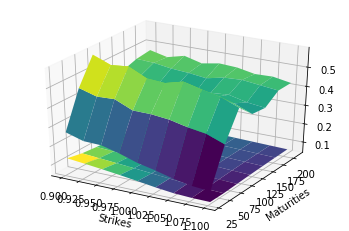

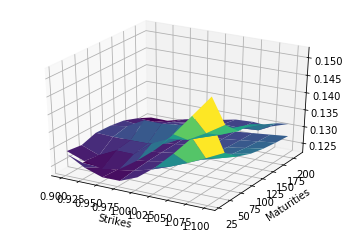

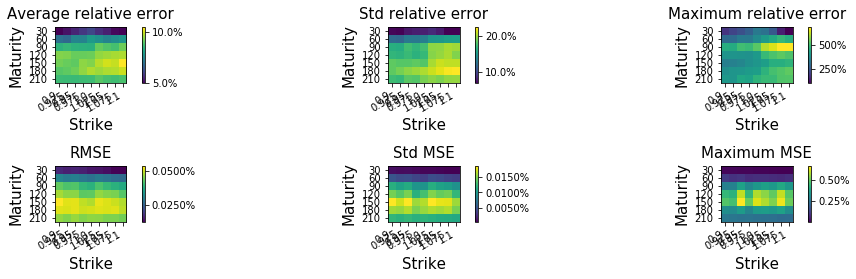

In [19]:
prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
forecast = NN1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
y_true_test = y_test_trafo2.reshape(Ntest,Nmaturities,Nstrikes)
# Example Plots
X = strikes
Y = maturities
X, Y = np.meshgrid(X, Y)
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
import random
sample_idx = random.randint(0,len(y_test))

#error plots
mape = np.zeros(forecast.shape)
mse  = np.zeros(forecast.shape)
for i in range(Ntest):
    mape[i,:,:] =  np.abs((y_true_test[i,:,:]-forecast[i,:,:])/y_true_test[i,:,:])
    mse[i,:,:]  =  np.square((y_true_test[i,:,:]-forecast[i,:,:]))
idx = np.argsort(np.max(mape,axis=tuple([1,2])), axis=None)

#bad_idx = idx[:-200]
bad_idx = idx
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, y_true_test[idx[-1],:,:], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.plot_surface(X, Y, forecast[idx[-1],:,:] , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
plt.show()
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, y_true_test[sample_idx,:,:], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.plot_surface(X, Y, forecast[sample_idx,:,:] , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
plt.show()
#from matplotlib.colors import LogNorm
plt.figure(figsize=(14,4))
ax=plt.subplot(2,3,1)
err1 = 100*np.mean(mape[bad_idx,:,:],axis=0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,2)
err2 = 100*np.std(mape[bad_idx,:,:],axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,3)
err3 = 100*np.max(mape[bad_idx,:,:],axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,4)
err1 = np.sqrt(np.mean(mse[bad_idx,:,:],axis=0))
plt.title("RMSE",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,5)
err2 = np.std(mse[bad_idx,:,:],axis = 0)
plt.title("Std MSE",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,6)
err3 = np.max(mse[bad_idx,:,:],axis = 0)
plt.title("Maximum MSE",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.show()

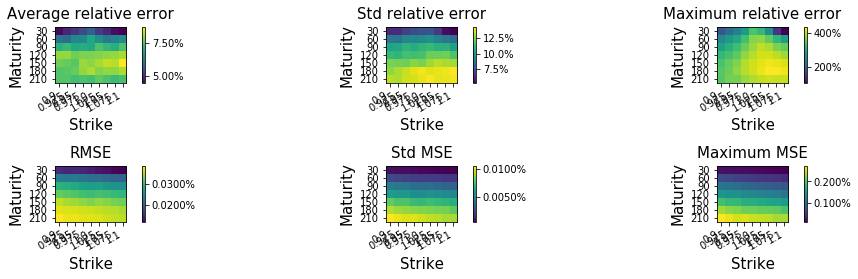

In [24]:
#from matplotlib.colors import LogNorm
plt.figure(figsize=(14,4))
fig.suptitle('Error with no constrain violation', fontsize=16)
ax=plt.subplot(2,3,1)
bad_idx = testing_violation2
err1 = 100*np.mean(mape[bad_idx,:,:],axis=0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,2)
err2 = 100*np.std(mape[bad_idx,:,:],axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,3)
err3 = 100*np.max(mape[bad_idx,:,:],axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,4)
err1 = np.sqrt(np.mean(mse[bad_idx,:,:],axis=0))
plt.title("RMSE",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,5)
err2 = np.std(mse[bad_idx,:,:],axis = 0)
plt.title("Std MSE",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,6)
err3 = np.max(mse[bad_idx,:,:],axis = 0)
plt.title("Maximum MSE",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.show()

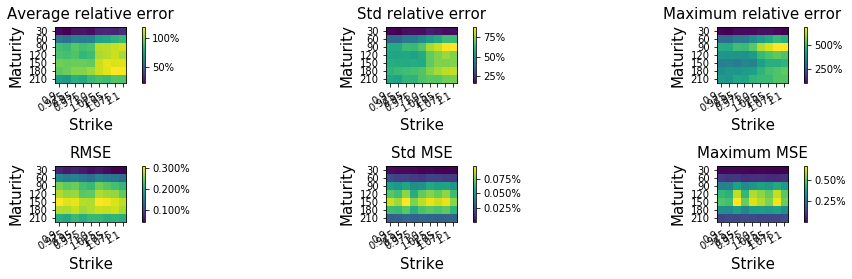

In [25]:
#from matplotlib.colors import LogNorm
plt.figure(figsize=(14,4))
plt.suptitle('Error with constraint violation', fontsize=16)
ax=plt.subplot(2,3,1)
bad_idx = testing_violation
err1 = 100*np.mean(mape[bad_idx,:,:],axis=0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,2)
err2 = 100*np.std(mape[bad_idx,:,:],axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,3)
err3 = 100*np.max(mape[bad_idx,:,:],axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,4)
err1 = np.sqrt(np.mean(mse[bad_idx,:,:],axis=0))
plt.title("RMSE",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,5)
err2 = np.std(mse[bad_idx,:,:],axis = 0)
plt.title("Std MSE",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,6)
err3 = np.max(mse[bad_idx,:,:],axis = 0)
plt.title("Maximum MSE",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.show()

# 5. FFNN as Encoder / Pricing Kernel - Approach of Horvath (improved)

In [34]:
X_test_trafo3  = X_test_trafo.reshape((Ntest,5))
X_train_trafo3 = X_train_trafo.reshape((Ntrain,5))
X_val_trafo3   = X_val_trafo.reshape((Nval,5))
#Neural Network
keras.backend.set_floatx('float64')
NN3 = Sequential()
NN3.add(InputLayer(input_shape=(Nparameters,)))
NN3.add(Dense(30, activation = 'elu'))
NN3.add(Dense(30, activation = 'elu'))
#NN3.add(Dropout(0.05))
NN3.add(Dense(30, activation = 'relu'))
NN3.add(Dense(Nstrikes*Nmaturities, activation = 'linear', use_bias=True,kernel_constraint = keras.constraints.NonNeg()))
NN3.summary()
"""
#Neural Network Horvath
NN4 = Sequential()
NN4.add(InputLayer(input_shape=(Nparameters,)))
NN4.add(Dense(30, activation = 'elu'))
NN4.add(Dense(30, activation = 'elu'))
NN4.add(Dense(30, activation = 'elu'))
NN4.add(Dense(Nstrikes*Nmaturities, activation = 'linear'))
NN4.summary()
"""               
NN3.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MSE","MAPE"])
#NN3.compile(loss = "mean_squared_error", optimizer = "adam",metrics=["MAPE"])
#NN3.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","mean_squared_error"])
#NN3.compile(loss = 'mean_absolute_percentage_error', optimizer = "adam")
NN3.fit(X_train_trafo3, y_train, batch_size=32, validation_data = (X_val_trafo3, y_val),
        epochs = 200, verbose = True, shuffle=1)
#NN4.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MSE"])
#NN4.compile(loss = "mean_squared_error", optimizer = "adam",metrics=["MAPE"])
#NN4.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","mean_squared_error"])
#NN4.compile(loss = 'mean_absolute_percentage_error', optimizer = "adam")
#NN4.fit(X_train_trafo3, y_train, batch_size=32, validation_data = (X_val_trafo3, y_val),
#       epochs = 200, verbose = True, shuffle=1)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 30)                180       
_________________________________________________________________
dense_61 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_62 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_63 (Dense)             (None, 63)                1953      
Total params: 3,993
Trainable params: 3,993
Non-trainable params: 0
_________________________________________________________________
Train on 36085 samples, validate on 6369 samples
Epoch 1/200
36085/36085 [==============================] - 3s 92us/step - loss: 0.5255 - mean_squared_error: 0.0112 - val_loss: 0.4980 - val_mean_squared_error: 0.0109
Epoch 2/200
36085/36085 [==============================

36085/36085 [==============================] - 2s 44us/step - loss: 0.4915 - mean_squared_error: 0.0108 - val_loss: 0.4954 - val_mean_squared_error: 0.0111
Epoch 93/200
36085/36085 [==============================] - 2s 43us/step - loss: 0.4914 - mean_squared_error: 0.0108 - val_loss: 0.4964 - val_mean_squared_error: 0.0113
Epoch 94/200
36085/36085 [==============================] - 2s 43us/step - loss: 0.4917 - mean_squared_error: 0.0109 - val_loss: 0.4953 - val_mean_squared_error: 0.0109
Epoch 95/200
36085/36085 [==============================] - 2s 43us/step - loss: 0.4915 - mean_squared_error: 0.0108 - val_loss: 0.4952 - val_mean_squared_error: 0.0109
Epoch 96/200
36085/36085 [==============================] - 2s 47us/step - loss: 0.4916 - mean_squared_error: 0.0108 - val_loss: 0.4971 - val_mean_squared_error: 0.0105
Epoch 97/200
36085/36085 [==============================] - 2s 46us/step - loss: 0.4913 - mean_squared_error: 0.0108 - val_loss: 0.4952 - val_mean_squared_error: 0.0109

36085/36085 [==============================] - 2s 43us/step - loss: 0.4914 - mean_squared_error: 0.0108 - val_loss: 0.4952 - val_mean_squared_error: 0.0110
Epoch 189/200
36085/36085 [==============================] - 2s 49us/step - loss: 0.4912 - mean_squared_error: 0.0108 - val_loss: 0.4953 - val_mean_squared_error: 0.0109
Epoch 190/200
36085/36085 [==============================] - 2s 52us/step - loss: 0.4916 - mean_squared_error: 0.0108 - val_loss: 0.4952 - val_mean_squared_error: 0.0109
Epoch 191/200
36085/36085 [==============================] - 2s 58us/step - loss: 0.4911 - mean_squared_error: 0.0108 - val_loss: 0.4953 - val_mean_squared_error: 0.0109
Epoch 192/200
36085/36085 [==============================] - 3s 74us/step - loss: 0.4915 - mean_squared_error: 0.0108 - val_loss: 0.4963 - val_mean_squared_error: 0.0113
Epoch 193/200
36085/36085 [==============================] - 3s 87us/step - loss: 0.4914 - mean_squared_error: 0.0108 - val_loss: 0.4952 - val_mean_squared_error: 0

### 5.1 Results
__Following results are not correct!!__

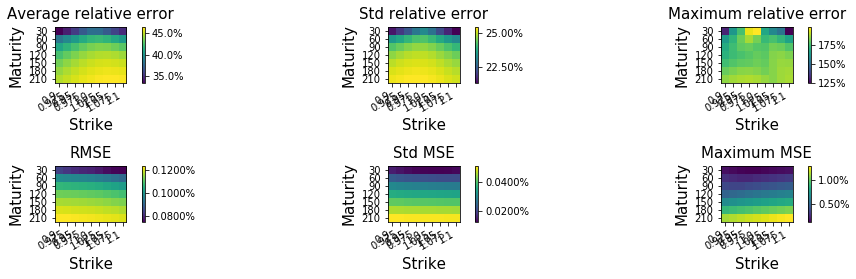

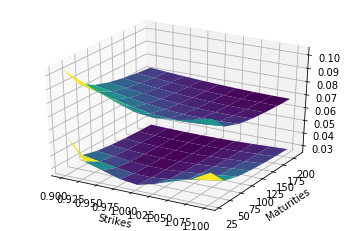

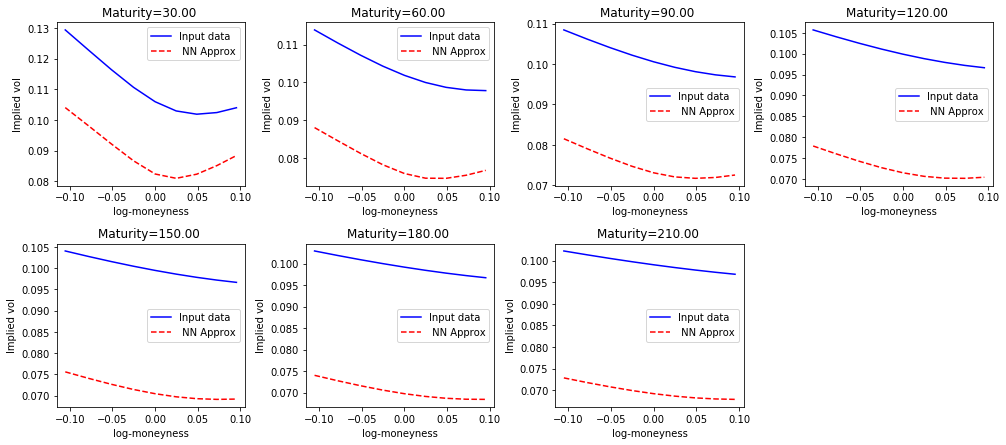

In [36]:
#error plots
S0=1.
y_test_re       = yinversetransform(y_test)
prediction_list = [yinversetransform(NN3.predict(X_test_trafo3[i].reshape(1,Nparameters))[0]) for i in range(len(X_test_trafo3))]
prediction      = np.asarray(prediction_list)
Ntest           = prediction.shape[0]
err_rel_list = np.abs((y_test_re-prediction)/y_test_re)
err_rel_mat  = err_rel_list.reshape((Ntest,Nmaturities,Nstrikes))
idx = np.argsort(np.max(err_rel_mat,axis=tuple([1,2])), axis=None)
#bad_idx = idx[:-200]
err_list = np.square((y_test_re-prediction))
err_mat  = err_list.reshape((Ntest,Nmaturities,Nstrikes))
bad_idx = idx
#from matplotlib.colors import LogNorm
plt.figure(figsize=(14,4))
ax=plt.subplot(2,3,1)
err1 = 100*np.mean(err_rel_mat[bad_idx,:,:],axis=0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,2)
err2 = 100*np.std(err_rel_mat[bad_idx,:,:],axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,3)
err3 = 100*np.max(err_rel_mat[bad_idx,:,:],axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,4)
err1 = np.sqrt(np.mean(err_mat[bad_idx,:,:],axis=0))
plt.title("RMSE",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,5)
err2 = np.std(err_mat[bad_idx,:,:],axis = 0)
plt.title("Std MSE",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,6)
err3 = np.max(err_mat[bad_idx,:,:],axis = 0)
plt.title("Maximum MSE",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.savefig('HNG_NN_old_Errors.png', dpi=300)
plt.show()



#==============================================================================
#surface
import random
test_sample = random.randint(0,len(y_test))
test_sample = idx[-1]
#test_sample = idx[0]

y_test_sample = y_test_re[test_sample,:]
y_predict_sample = prediction_list[test_sample]
y_test_sample_p = np.reshape(y_test_sample, (Nmaturities, Nstrikes))
y_predict_sample_p = np.reshape(y_predict_sample, (Nmaturities, Nstrikes))
diff = y_test_sample_p-y_predict_sample_p 
rel_diff = np.abs(y_test_sample_p-y_predict_sample_p)/(y_test_sample_p)
    
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = strikes
Y = maturities
X, Y = np.meshgrid(X, Y)


#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, y_test_sample_p, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.plot_surface(X, Y, y_predict_sample_p , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
#ax.plot_surface(X, Y, rel_diff, rstride=1, cstride=1,
#                cmap='viridis', edgecolor='none')
ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
#ax.set_zlabel('rel. err');
plt.show()


#==============================================================================
#smile
sample_ind = 13
X_sample = X_test_trafo3[sample_ind]
y_sample = y_test[sample_ind]
#print(scale.inverse_transform(y_sample))

prediction=yinversetransform(NN3.predict(X_sample.reshape(1,Nparameters))[0])
plt.figure(figsize=(14,12))
for i in range(Nmaturities):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),y_sample[i*Nstrikes:(i+1)*Nstrikes],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*Nstrikes:(i+1)*Nstrikes],'--r',label=" NN Approx")
    #plt.ylim(0.22, 0.26)
    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.savefig('HNG_old_smile.png', dpi=300)
plt.show()
